# Harris Corner Detection Project
**Project: Feature Detection and Robustness Testing**

### Introduction
This project implements the Harris Corner Detector using OpenCV. The goal is to detect corners in a sample chessboard image and five specific test images. Furthermore, the algorithm is optimized for sub-pixel accuracy, and its robustness is tested under rotation and scaling transformations.

## Part 1: Implementation on Sample Image (Chessboard)
First, I implemented the basic Harris Corner Detection on `chessboard.jpg` to verify the algorithm. The steps below visualize the intermediate processing stages: Grayscale conversion, Harris Response, Dilation, and the final detection.

In [31]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Alias cv to cv2
cv2 = cv

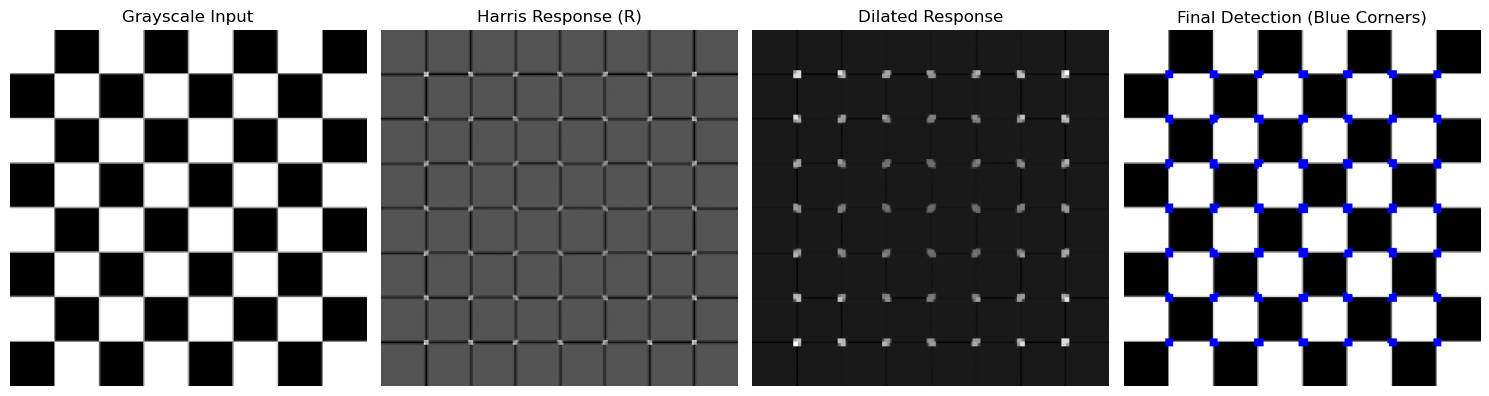

In [82]:
# Load the sample image
filename = 'chessboard.jpg'
img = cv.imread(filename)

if img is not None:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    # 1. Apply Harris Corner Detector
    dst = cv.cornerHarris(gray, 2, 3, 0.04)
    
    # 2. Dilate result to enhance corner points for visualization
    dst_dilated = cv.dilate(dst, None)
    
    # 3. Thresholding and Visualization
    img_harris = img.copy()
    # Marking corners in Blue (BGR: 255, 0, 0)
    img_harris[dst_dilated > 0.01 * dst_dilated.max()] = [255, 0, 0]
    
    # Plotting intermediate results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 4, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(dst, cmap='gray')
    plt.title('Harris Response (R)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(dst_dilated, cmap='gray')
    plt.title('Dilated Response')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(cv.cvtColor(img_harris, cv.COLOR_BGR2RGB))
    plt.title('Final Detection (Blue Corners)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: {filename} not found.")

## Part 2: Initial Testing on Project Images
Testing the default Harris detector parameters (`blockSize=2`, `ksize=3`, `k=0.04`) on the five provided project images to establish a baseline.

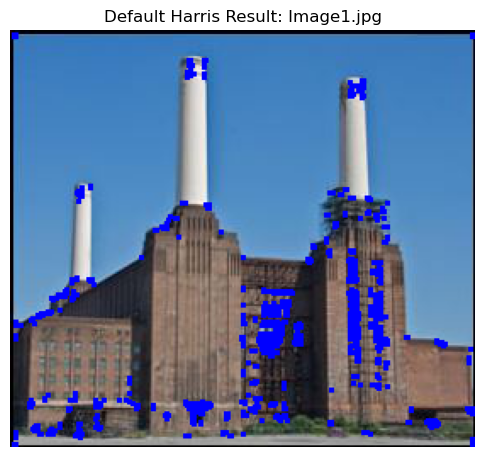

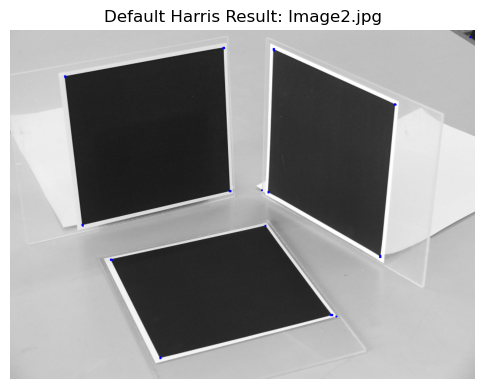

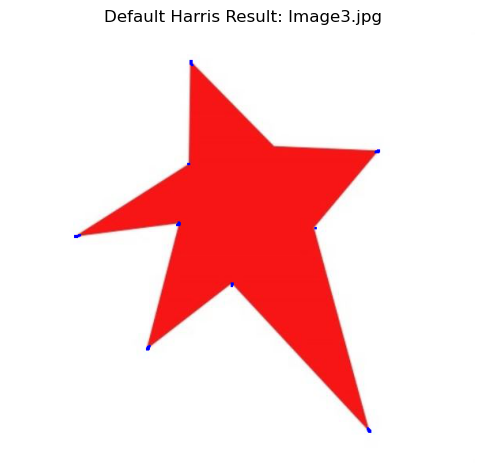

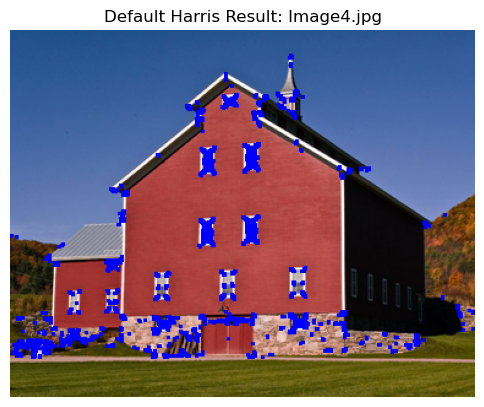

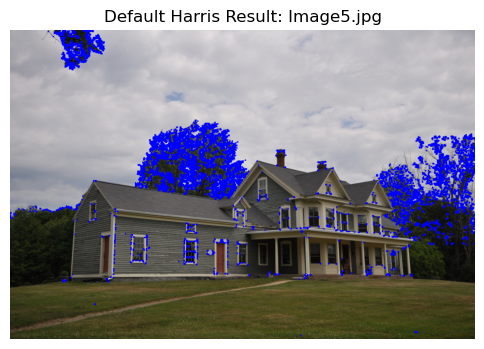

In [33]:
image_files = ['Image1.jpg', 'Image2.jpg', 'Image3.jpg', 'Image4.jpg', 'Image5.jpg']

def default_harris_corner(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"Could not load {img_path}")
        return
        
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    
    # Standard Harris Detection
    dst = cv.cornerHarris(gray, 2, 3, 0.04)
    dst = cv.dilate(dst, None)
    
    img_out = img.copy()
    # Thresholding (Blue Corners)
    img_out[dst > 0.01 * dst.max()] = [255, 0, 0]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv.cvtColor(img_out, cv.COLOR_BGR2RGB))
    plt.title(f'Default Harris Result: {img_path}')
    plt.axis('off')
    plt.show()

# Executing on all test images
for f in image_files:
    default_harris_corner(f)

## Part 3: Sub-Pixel Accuracy Optimization
To improve precision, I implemented `cv2.cornerSubPix`. This refines the integer corner coordinates to floating-point values. The parameters were tuned to ensure stable detection across complex images.

In [34]:
def optimized_subpixel_corner(img_path, blockSize=2, ksize=3, k=0.04, thresh_ratio=0.01):
    """
    Applies Harris Corner Detection followed by Sub-Pixel refinement.
    """
    img = cv2.imread(img_path)
    if img is None:
        return
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    
    # 1. Coarse Detection
    dst = cv2.cornerHarris(gray, blockSize, ksize, k)
    dst_dil = cv2.dilate(dst, None)
    
    # 2. Extract Centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(
        np.uint8(dst_dil > thresh_ratio * dst_dil.max())
    )
    
    # 3. Refine to Sub-Pixel Accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    refined_corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)
    
    # Filter background (index 0)
    valid_corners = refined_corners[1:]
    
    # 4. Visualization
    res_img = img.copy()
    for i in range(len(valid_corners)):
        x, y = valid_corners[i]
        # Draw Blue circle (BGR: 255, 0, 0)
        cv2.circle(res_img, (int(x), int(y)), 3, (255, 0, 0), -1)
        
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Optimized SubPixel: {img_path}\nDetected Corners: {len(valid_corners)}')
    plt.axis('off')
    plt.show()
    return valid_corners

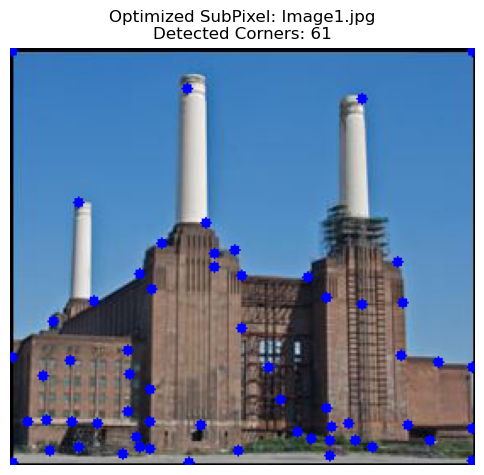

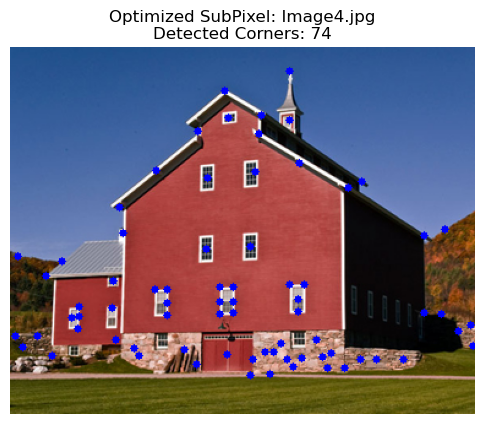

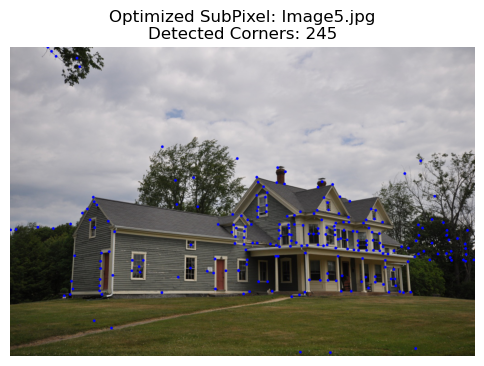

In [35]:
# Applying optimized parameters to all dataset images
for f in image_files:
    # Increased blockSize to 4 for stability, adjusted threshold for sensitivity
    optimized_subpixel_corner(f, blockSize=4, ksize=3, k=0.04, thresh_ratio=0.005)

## Part 4: Robustness Testing (Rotation & Scaling)
I conducted a stress test on `Image5.jpg` to verify the detector's repeatability. 

**Methodology:**
1. **Rotation:** The image is rotated from 0 to 360 degrees.
2. **Scaling:** The image is scaled from 0.5x (zoom out) to 1.5x (zoom in).
3. **Accuracy Calculation:** The corners detected in the transformed images are matched against the ground truth (original image corners projected onto the new coordinates). A high accuracy score confirms that the feature detector is invariant to these transformations.

In [80]:
# Function to calculate detection repeatability (Accuracy)
def calculate_accuracy(original_corners, detected_corners, M, shape_original):
    if len(original_corners) == 0: return 0.0

    # Project original corners to the transformed coordinate system
    ones = np.ones((original_corners.shape[0], 1))
    pts_homo = np.hstack([original_corners, ones])
    predicted_pts = M.dot(pts_homo.T).T
    
    matched_count = 0
    threshold_dist = 5.0 # Tolerance in pixels
    h, w = shape_original
    
    for pred in predicted_pts:
        px, py = pred
        # Check if point is within image bounds
        if 0 <= px < w and 0 <= py < h:
            if len(detected_corners) > 0:
                # Calculate distance to nearest detected corner
                dists = np.linalg.norm(detected_corners - pred, axis=1)
                if np.min(dists) <= threshold_dist:
                    matched_count += 1
    
    return (matched_count / len(original_corners)) * 100

def run_stress_test(img_name):
    print(f"--- Running Robustness Test on {img_name} ---")
    
    # Load Image and Establish Ground Truth
    img = cv2.imread(img_name)
    if img is None: 
        print("Image not found")
        return
    
    gray_orig = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_float = np.float32(gray_orig)
    
    # Base Detection
    dst = cv2.cornerHarris(gray_float, 4, 3, 0.04)
    dst_dil = cv2.dilate(dst, None)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(dst_dil > 0.005 * dst_dil.max()))
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    orig_corners = cv2.cornerSubPix(gray_float, np.float32(centroids), (5, 5), (-1, -1), criteria)[1:]
    
    rows, cols = gray_orig.shape
    center = (cols / 2, rows / 2)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- ROTATION TEST ---
    angles = range(0, 365, 30)
    rot_accuracies = []
    rot_imgs = []
    
    for angle in angles:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rot_gray = cv2.warpAffine(gray_float, M, (cols, rows))
        
        # Detect on rotated image
        dst = cv2.cornerHarris(rot_gray, 4, 3, 0.04)
        dst_dil = cv2.dilate(dst, None)
        ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(dst_dil > 0.005 * dst_dil.max()))
        
        detected = np.array([])
        if len(centroids) > 1:
            detected = cv2.cornerSubPix(rot_gray, np.float32(centroids), (5, 5), (-1, -1), criteria)[1:]
            
        acc = calculate_accuracy(orig_corners, detected, M, (rows, cols))
        rot_accuracies.append(acc)
        
        # Visualization
        v_img = cv2.warpAffine(img_rgb, M, (cols, rows))
        for p in detected:
            # Draw Blue corners (BGR: 255, 0, 0)
            cv2.circle(v_img, (int(p[0]), int(p[1])), 5, (255, 0, 0), -1)
        rot_imgs.append((angle, v_img))

    # --- SCALING TEST ---
    scales = [0.5, 0.75, 0.9, 1.0, 1.1, 1.25, 1.5]
    scale_accuracies = []
    scale_imgs = []
    
    for scale in scales:
        M = cv2.getRotationMatrix2D(center, 0, scale)
        scaled_gray = cv2.warpAffine(gray_float, M, (cols, rows))
        
        # Detect on scaled image
        dst = cv2.cornerHarris(scaled_gray, 4, 3, 0.04)
        dst_dil = cv2.dilate(dst, None)
        ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(dst_dil > 0.005 * dst_dil.max()))
        
        detected = np.array([])
        if len(centroids) > 1:
            detected = cv2.cornerSubPix(scaled_gray, np.float32(centroids), (5, 5), (-1, -1), criteria)[1:]
            
        acc = calculate_accuracy(orig_corners, detected, M, (rows, cols))
        scale_accuracies.append(acc)
        
        # Visualization
        v_img = cv2.warpAffine(img_rgb, M, (cols, rows))
        for p in detected:
            # Draw Blue corners (BGR: 255, 0, 0)
            cv2.circle(v_img, (int(p[0]), int(p[1])), 5, (255, 0, 0), -1)
        
        lbl = f"Zoom {scale}x"
        if scale < 1.0: lbl += " (Out)"
        elif scale > 1.0: lbl += " (In)"
        scale_imgs.append((lbl, v_img))

    # --- PLOTTING RESULTS ---
    
    # 1. Accuracy Plots
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(angles, rot_accuracies, '-o', color='purple')
    plt.title("Rotation Robustness")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(scales, scale_accuracies, '-s', color='orange')
    plt.title("Scaling Robustness")
    plt.xlabel("Scale Factor")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.show()
    
    # 2. Rotation Visualization Grid
    cols_plot = 5
    rows_plot = (len(rot_imgs) // cols_plot) + 1
    plt.figure(figsize=(15, 8))
    for i, (ang, v_img) in enumerate(rot_imgs):
        plt.subplot(rows_plot, cols_plot, i+1)
        plt.imshow(v_img)
        plt.title(f"{ang}°")
        plt.axis('off')
    plt.suptitle("Rotation Results (Blue Corners)")
    plt.tight_layout()
    plt.show()
    
    # 3. Scaling Visualization Grid
    plt.figure(figsize=(20, 8))
    for i, (lbl, v_img) in enumerate(scale_imgs):
        plt.subplot(2, len(scale_imgs)//2 + 1, i+1)
        plt.imshow(v_img)
        plt.title(lbl)
        plt.axis('off')
    plt.suptitle("Scaling Results (Blue Corners)")
    plt.tight_layout()
    plt.show()

--- Running Robustness Test on Image5.jpg ---


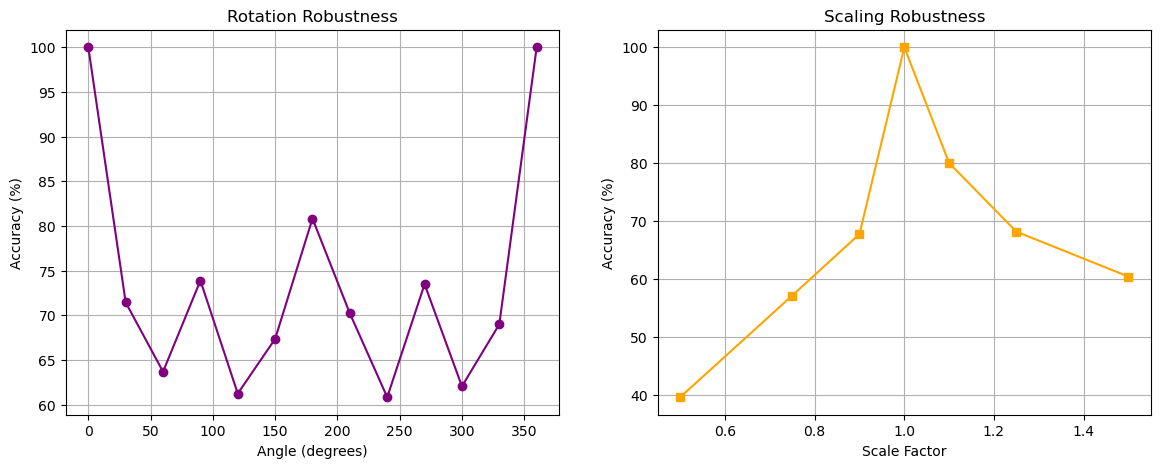

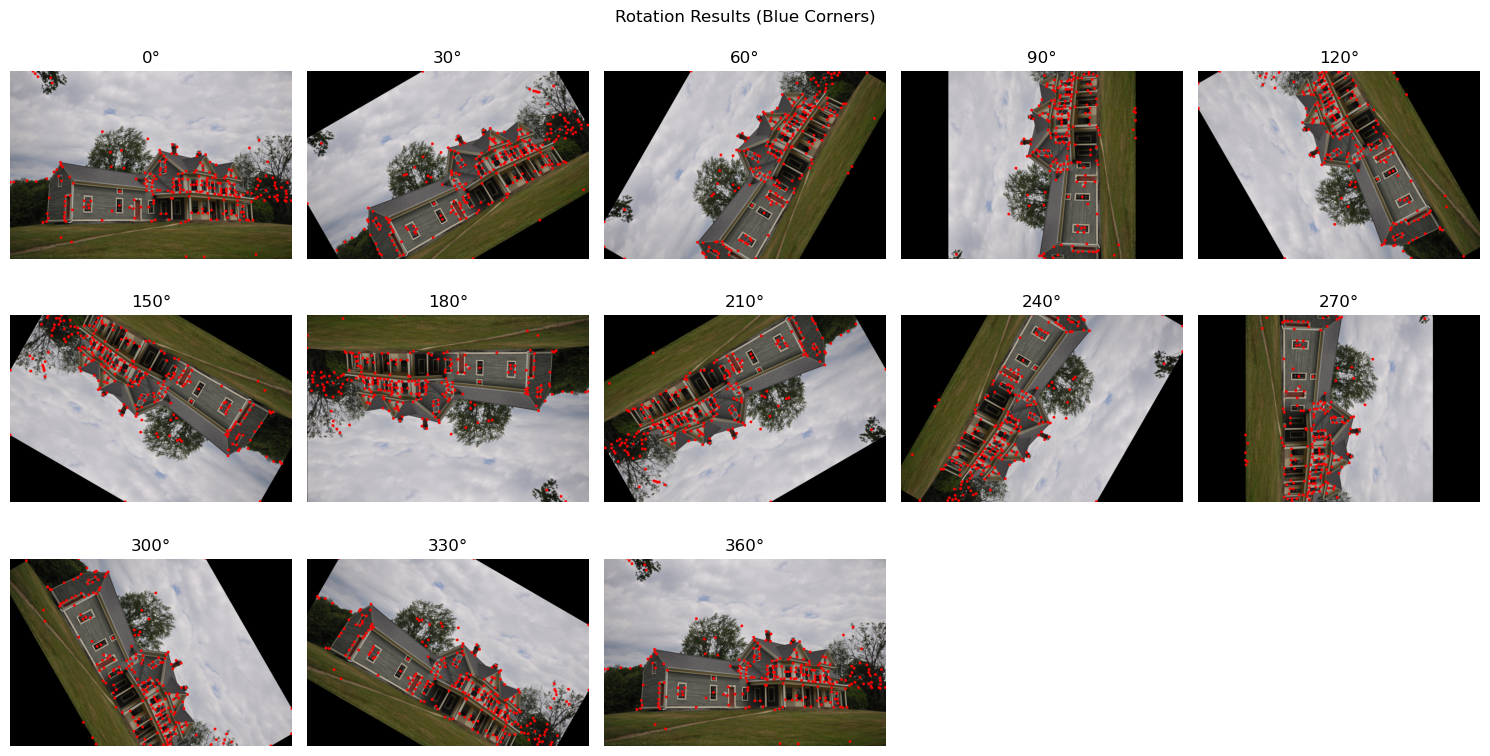

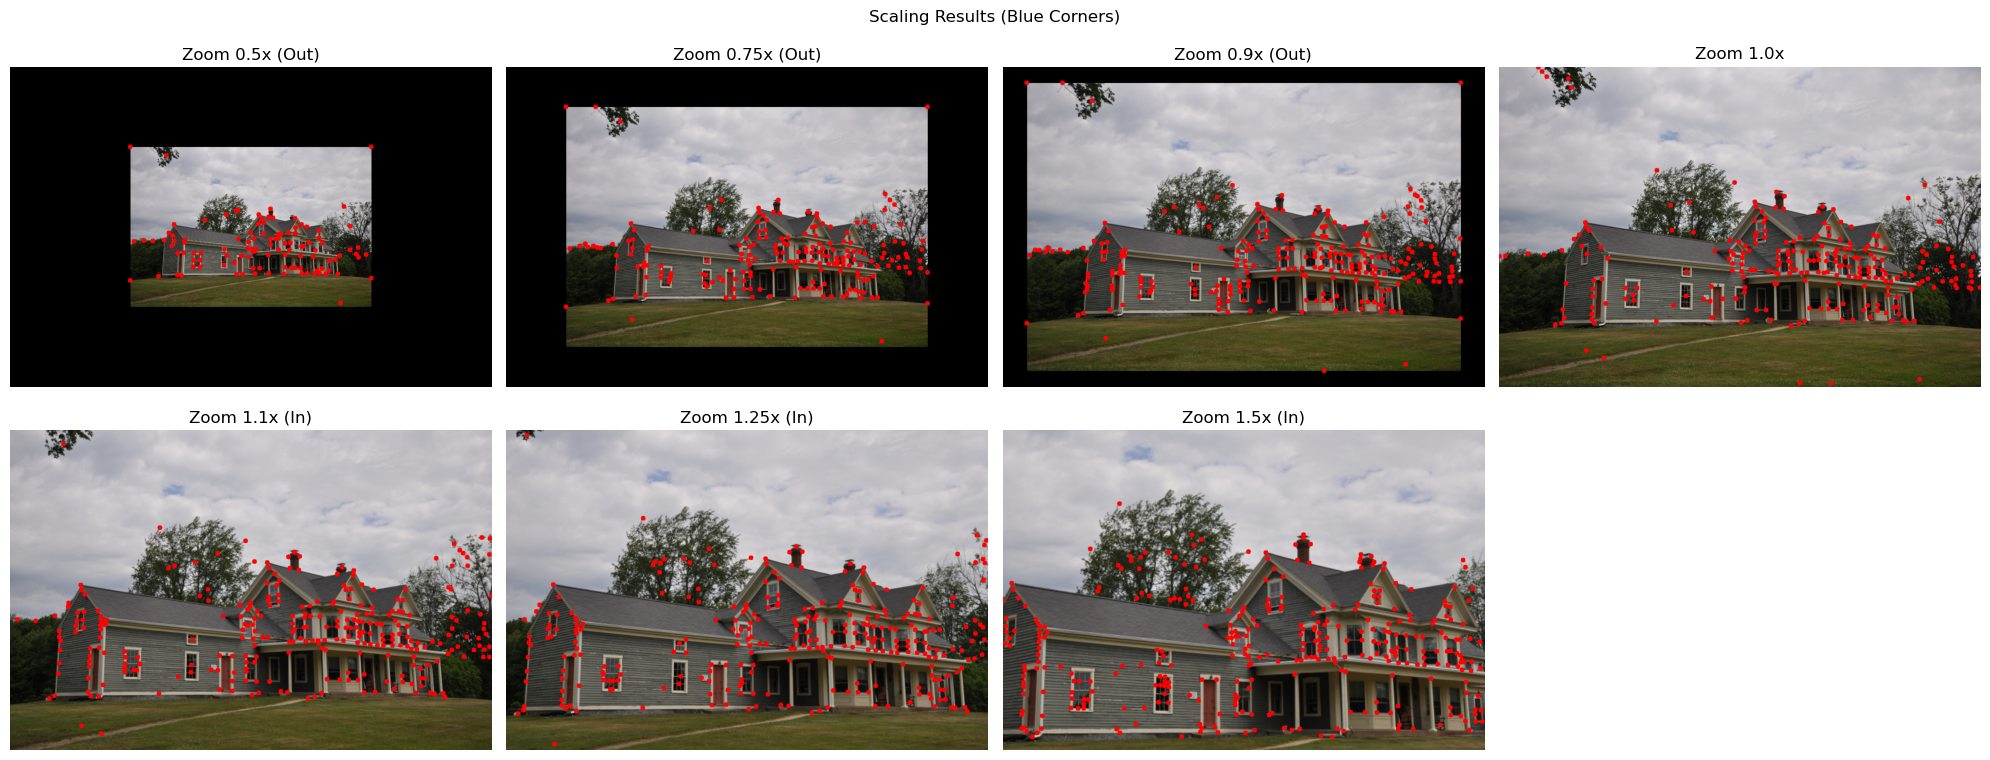

In [81]:
# Execute stress test on Image5
run_stress_test('Image5.jpg')